In [1]:
import numpy as np
import os.path as osp
import pandas as pd
from collections import defaultdict
from sklearn.neighbors import NearestNeighbors  # Students: you can use this implementation to find the 
                                                # Nearest-Neigbors
import sys
sys.path.append('../..')
from cs233_gtda_hw4.losses import EncodingDistance

In [2]:
# Load golden distances (pairwise matrix, or corresponding model/part names in golden_names)
golden_part_dist_file = '../data/golden_dists.npz'
golden_data = np.load(golden_part_dist_file, allow_pickle=True)
golden_part_dist = golden_data['golden_part_dist']
golden_names = golden_data['golden_names']

484
c59cdd1537bd75ddd0818327fc390a5__2__


In [3]:
# Load/organize golden part-aware distances.
sn_id_to_parts = defaultdict(list)
id_to_part_loc = dict()

for i, name in enumerate(golden_names):
    # Extract shape-net model ids of golden, map them to their parts.
    sn_id, _, part_id, _, _ = name.split('_')
    sn_id_to_parts[sn_id].append(part_id)
    
    # Map shape-net model id and part_id to location in distance matrix, (the order is the same).
    id_to_part_loc[(sn_id, part_id)] = i

In [4]:
out_n = 1024
enc_dist = EncodingDistance('../data/golden_dists.npz')

def measure_part_awareness(model_tag, return_df=False):
    if model_tag != 'random':
        ae_emb_file = f'../data/out/{model_tag}_latent_codes.npz'
        in_d = np.load(ae_emb_file)

        latent_codes = in_d['latent_codes']
        test_names = in_d['test_names']
    else:
        latent_codes = np.random.rand(len(test_names), 123)

    res = enc_dist.calculate(latent_codes, test_names, return_df)
    
    if return_df:
        return res
    
    res['model_tag'] = model_tag
    return res

    # print(f'''
    #     {model_tag} PART AWARENESS: \n
    #     Cumulative encoding distance = {encoding_distances.sum():.4f} 
    #     Avg. shared parts = {num_shared_parts.mean():.2f} 
    #     Avg. latent distance = {latent_distances.mean():.2f}    
    # ''')
    
    # return {
    #     'model_tag': model_tag,
    #     'enc_dist': encoding_distances.sum(),
    #     'shared_pts': num_shared_parts.mean(),
    #     'latent_dist': latent_distances.mean()
    # }

In [6]:
data = []
tags = [f'pc_ae_out{out_n}_', f'part_pc_ae_out{out_n}_', f'experiment_',
        f'experiment_drop0.15_bnorm_',
        'experiment_drop0.15_bnorm_decay0.8_alpha1e-5_',
       'experiment_drop0.15_bnorm_decay0.8_alpha1e-6_',
       'experiment_drop0.15_bnorm_decay0.7_alpha1e-6_',
       'experiment_kl5e-5_noisy_', 'experiment_kl5e-5_noisy2e-2_',
        'experiment_drop0.15_bnorm_kl5e-5_noisy2e-2_', 
        'experiment_drop0.2_bnorm_kl5e-05_noisy0.005_cdec0.7_alpha1e-06_',
        'experiment_drop0.2_bnorm_kl1e-05_noisy0.005_cdec0.7_alpha1e-06_kdec1.1_',
        'experiment_drop0.15_bnorm_kl1e-05_noisy0.01_cdec0.7_alpha1e-05_kdec1_',
        'experiment_drop0.15_bnorm_kl1e-05_noisy0.001_cdec0.7_alpha1e-05_kdec1_',
        # 'experiment_drop0.2_bnorm_kl1e-05_noisy0.005_cdec0.85_alpha1e-05_kdec1.4_', # 412
        # 'experiment_drop0.2_bnorm_kl1e-05_noisy0.005_cdec0.85_alpha1e-06_kdec1.4_', $ 405
       ]
for model_tag in tags:
    data.append(measure_part_awareness(model_tag))
pd.DataFrame(data)

,enc_dist,shared_pts,latent_dist,model_tag
0,419.535706,3.160000,0.226930,pc_ae_out1024_
1,407.600302,3.180000,0.311324,part_pc_ae_out1024_
2,412.147745,3.146667,0.229384,experiment_
3,382.428042,3.173333,0.556023,experiment_drop0.15_bnorm_
4,405.770041,3.160000,0.531155,experiment_drop0.15_bnorm_decay0.8_alpha1e-5_
5,389.672346,3.160000,0.649659,experiment_drop0.15_bnorm_decay0.8_alpha1e-6_
6,390.321417,3.166667,0.681365,experiment_drop0.15_bnorm_decay0.7_alpha1e-6_
7,402.218711,3.153333,1.740098,experiment_kl5e-5_noisy_
8,407.687951,3.153333,0.895510,experiment_kl5e-5_noisy2e-2_
9,408.786409,3.160000,2.316503,experiment_drop0.15_bnorm_kl5e-5_noisy2e-2_


In [7]:
# BEST POSSIBLE PART DISTANCES
ae_emb_file = f'../data/out/{model_tag}_latent_codes.npz'
in_d = np.load(ae_emb_file)

latent_codes = in_d['latent_codes']
test_names = in_d['test_names']
encoding_distances = np.zeros(len(test_names))

data = []
for i, sn_name in enumerate(test_names):
    parts_of_model = set(sn_id_to_parts[sn_name])

    min_distance = np.inf
    # greedily search for the best possible match
    for matched_neighbor in test_names:
        if matched_neighbor == sn_name:
            continue
        distance = 0
        parts_of_neighbor = set(sn_id_to_parts[matched_neighbor])

        # compute the requested distances.
        # Use id_to_part_loc for each model/part combination
        parts_in_both = parts_of_model.intersection(parts_of_neighbor)
        for k in parts_in_both:
            distance += golden_part_dist[id_to_part_loc[(sn_name, k)], id_to_part_loc[(matched_neighbor, k)]]

        parts_only_model = parts_of_model.difference(parts_of_neighbor)
        parts_only_neighbor = parts_of_neighbor.difference(parts_of_model)
        # for k in parts_only_A:
        #     distance += max([golden_part_dist[id_to_part_loc[(matched_neighbor, k)], id_to_part_loc[(sn_name, u)]] for u in parts_of_model])

        # part distance as in homework
        cand_distances = [0] * 4
        for u in parts_of_model:
            for k in parts_only_neighbor:
                cand_distances[int(u) - 1] += golden_part_dist[
                    id_to_part_loc[(matched_neighbor, k)], id_to_part_loc[(sn_name, u)]]
        distance += max(cand_distances)
        
        if distance < min_distance:
            min_distance = distance
            best_neighbor = matched_neighbor
    encoding_distances[i] = min_distance
    data.append({'name': sn_name, 'match': best_neighbor, 'dist': min_distance})

print(f'''
    IDEAL PART AWARENESS: \n
    Cumulative encoding distance = {encoding_distances.sum():.4f}
''')

ideal_matches = pd.DataFrame(data)


    IDEAL PART AWARENESS: 

    Cumulative encoding distance = 322.3948



In [8]:
ideal_matches = pd.DataFrame(data)
ideal_matches

,name,match,dist
0,89509ce24bf62df0950baa3a522faef2,6e21df8cb8db3819899718fd4553951,2.701310
1,bbf45d2d189dcd758e5f5b49c9f5b3f2,79c9fdc6bba82709c8687ff9b0b4e4ac,2.399907
2,cd5ad4afabaed0d3e762624dc3c8fa2a,89f8c12dafc877009f8c3d2002c77ddb,2.755957
3,460eef2b90867427d9fad8aba2c312b7,243ab0d808fae5b76f1d1c49624bcfed,2.241070
4,40ab45735f526717e25492f5f62d416f,d3302b7fa6504cab1a461b43b8f257f,2.620148
...,...,...,...
145,f2ef238e2e4615e92cf8e80367b40c9a,76283716a2c6586e266d673a6188bf4c,1.045539
146,6cc65de3b510406ba0c5548d84070f68,5aea2a227125a81bccda8d28b44378b7,1.924996
147,d31ab2866270fb1c19fb4103277a6b93,ff5e8226b88c6b95741cdb62023d6a2f,4.360736
148,78e1977bc5f0f4041552c6ecbda964b,9515e377c1ec86529b9f2eb77f5e247e,1.251601


In [10]:
model_tag = 'exp_outn256_drop0.0_bnorm_kl1e-05_noisy0.005_cdec0.7_alpha1e-06_kdec1.15_predpts0.0005_predex0.0005_encpts_var_'
model_matches = measure_part_awareness(model_tag, return_df=True)

match_df = best_matches.merge(ideal_matches, on=['name'], suffixes=('_model', '_ideal'))
match_df['delta_dist'] = match_df.dist_model - match_df.dist_ideal
match_df[df.delta_dist > 1].sort_values('delta_dist', ascending=False)

In [35]:
from cs233_gtda_hw4.in_out.utils import make_data_loaders

top_in_dir = '../data/'
top_out_dir = '../data/out/'
if not osp.exists(top_out_dir):
    os.makedirs(top_out_dir)
    
top_log_dir = '../data/logs/'
if not osp.exists(top_log_dir):
    os.makedirs(top_log_dir)
    
loaders = make_data_loaders(top_in_dir, batch_size=128)

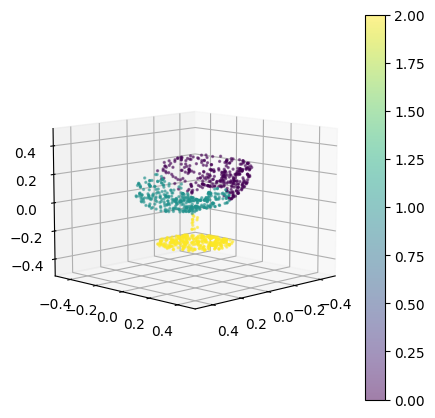

In [38]:
from cs233_gtda_hw4.in_out.plotting import plot_3d_point_cloud

model_name = '8a67fd47001e52414c350d7ea5fe2a3a'

for l in loaders['test']:
    if model_name in l['model_name']:
        for j in range(len(l['model_name'])):
            if l['model_name'][j] == model_name:
                pc = l['point_cloud'][j]
                tl = l['part_mask'][j]


_ = plot_3d_point_cloud(pc, c=tl, show=False, alpha=0.5, show_axis=True)